In [1]:
from __future__ import absolute_import, division, print_function

import os
import random
import numpy as np
import copy
from PIL import Image  

import PIL.Image as pil
from tqdm import tqdm
import torch
import torch.utils.data as data
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import skimage.transform
from collections import Counter
import time

import json

from utils import *
from kitti_utils import *
from layers import *
from Encoder import *
from depthDecoder import *

import datasets
import networks
from IPython import embed
cuda = torch.cuda.is_available()
cuda

True

In [2]:
dataset = datasets.KITTIRAWDataset 
data_path = "/home/ubuntu/monodepth2/kitti_data"
fpath_train = "/home/ubuntu/monodepth2/splits/eigen_full/train_files.txt"
f_train = open(fpath_train)
train_filenames = f_train.readlines()
fpath_val = "/home/ubuntu/monodepth2/splits/eigen_full/val_files.txt"
f_val = open(fpath_val)
val_filenames = f_val.readlines()

In [3]:
height = 192
width = 640
scales = np.arange(4)
img_ext = '.jpg'
#device = torch.device("cuda" if cuda else "cpu")
device = torch.device("cuda")
frame_ids = [0,'s']
weights_init = 'pretrained'
num_scales = len(scales)
num_input_frames = len(frame_ids)
num_layers = 18
learning_rate = 0.0001

In [4]:
batch_size = 16
num_workers = 8

train_dataset = dataset(data_path, train_filenames, height, width,frame_ids,num_scales,is_train=True, img_ext=img_ext)
train_loader = DataLoader(train_dataset, batch_size, True,num_workers=num_workers, pin_memory=True, drop_last=True)

val_dataset = dataset(data_path, val_filenames, height, width,frame_ids, 4, is_train=False, img_ext=img_ext)
val_loader = DataLoader(val_dataset, batch_size, True,num_workers=num_workers, pin_memory=True, drop_last=True)

In [5]:
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight.data)
    elif type(m) == nn.BatchNorm2d:
        #nn.init.constant_(m.weight, 1)
        nn.init.normal_(m.weight.data, mean=1, std=0.02)
        nn.init.constant_(m.bias, 0)

In [6]:
params = []
encoder = networks.ResnetEncoder(num_layers, True)
#encoder = ResnetEncoder()
#encoder.apply(init_weights)
params += list(encoder.parameters())

decoder = networks.DepthDecoder(encoder.num_ch_enc, scales)
#decoder = Decoder(encoder.num_ch_enc, scales)
#decoder.apply(init_weights)
params += list(decoder.parameters())
ssim = SSIM()
ssim.to(device)

encoder.to(device)
decoder.to(device)
optimizer = optim.Adam(params, learning_rate)

lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 15, 0.1)

depth_metric_names = [
            "de/abs_rel", "de/sq_rel", "de/rms", "de/log_rms", "da/a1", "da/a2", "da/a3"]


In [7]:
backproject_depth = {}
project_3d = {}
for scale in scales:
    h = height // (2 ** scale)
    w = width // (2 ** scale)

    backproject_depth[scale] = BackprojectDepth(batch_size, h, w)
    backproject_depth[scale].to(device)

    project_3d[scale] = Project3D(batch_size, h, w)
    project_3d[scale].to(device)
#print("There are {:d} training items and {:d} validation items\n".format(len(train_dataset), len(val_dataset)))

In [8]:

def generate_images_pred(inputs, outputs):
        
    frame_id = 's'
    source_scale = 0
    
    for scale in scales:
        disp = outputs[("disp", scale)]

        disp = F.interpolate(disp, [height, width], mode="bilinear",align_corners=False)
        
        depth = 1 / (0.01 + 9.99*disp)
 
        outputs[("depth", 0, scale)] = depth

        T = inputs["stereo_T"]

        cam_points = backproject_depth[source_scale](depth, inputs[("inv_K", source_scale)])
        pix_coords = project_3d[source_scale](cam_points, inputs[("K", source_scale)], T)
        outputs[("color", frame_id, scale)] = F.grid_sample(inputs[("color", frame_id, source_scale)],
                pix_coords,
                padding_mode="border",align_corners=False)

    return outputs   


In [9]:

def compute_reprojection_loss(pred, target):

        l1_loss = (torch.abs(target - pred)).mean(1,True)
        
        ssim_loss = ssim(pred, target).mean(1, True)
        reprojection_loss = 0.85*ssim_loss + 0.15 * l1_loss

        return reprojection_loss


In [10]:
def get_smooth_loss(disp, img):

    grad_disp_x = torch.abs(disp[:, :, :, :-1] - disp[:, :, :, 1:])
    grad_disp_y = torch.abs(disp[:, :, :-1, :] - disp[:, :, 1:, :])

    grad_img_x = torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:]), 1, keepdim=True)
    grad_img_y = torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]), 1, keepdim=True)

    grad_disp_x *= torch.exp(-grad_img_x)
    grad_disp_y *= torch.exp(-grad_img_y)

    return grad_disp_x.mean() + grad_disp_y.mean()


In [11]:

def compute_losses(inputs, outputs):

        losses = {}
        total_loss = 0
        frame_id = 's'

        for scale in scales:
            loss = 0
            reprojection_losses = []

            source_scale = 0

            disp = outputs[("disp", scale)]
            color = inputs[("color", 0, scale)]
            target = inputs[("color", 0, source_scale)]


            pred = outputs[("color", frame_id, scale)]
            reprojection_losses.append(compute_reprojection_loss(pred, target))

            reprojection_losses = torch.cat(reprojection_losses, 1)
            to_optimise, idxs = torch.min(reprojection_losses, dim=1)
            #to_optimise = reprojection_losses
            loss = loss + to_optimise.mean()

            norm_disp = disp / (disp.mean(2, True).mean(3, True)+ 1e-7)
            smooth_loss = get_smooth_loss(norm_disp, color)

            loss =  loss + ((1e-3)*smooth_loss) / (2 ** scale)
            total_loss = total_loss + loss
            losses["loss/{}".format(scale)] = loss

        total_loss = total_loss/num_scales
        losses["loss"] = total_loss
        return losses



In [12]:

def compute_depth_losses(inputs, outputs, losses):


        depth_pred = outputs[("depth", 0, 0)]
        depth_pred = torch.clamp(F.interpolate(
            depth_pred, [375, 1242], mode="bilinear", align_corners=False), min=1e-3, max=80)
        depth_pred = depth_pred.detach()

        depth_gt = inputs["depth_gt"]
        mask = depth_gt > 0

        crop_mask = torch.zeros_like(mask)
        crop_mask[:, :, 153:371, 44:1197] = 1
        mask = mask * crop_mask

        gt = depth_gt[mask]
        pred = depth_pred[mask]
        pred = pred*(torch.median(gt) / torch.median(pred))

        pred = torch.clamp(pred, min=1e-3, max=80)
        thresh = torch.max((gt / pred), (pred / gt))
        a1 = (thresh < 1.25     ).float().mean()
        a2 = (thresh < 1.25 ** 2).float().mean()
        a3 = (thresh < 1.25 ** 3).float().mean()

        rmse = torch.sqrt(((gt - pred)**2).mean())
        rmse_log = torch.sqrt(((torch.log(gt) - torch.log(pred))**2).mean())
        abs_rel = torch.mean(torch.abs(gt - pred) / gt)
        sq_rel = torch.mean(((gt - pred)**2 )/ gt)
        
        return np.array([abs_rel.item(),sq_rel.item(),rmse.item(),rmse_log.item(),a1.item(),a2.item(),a3.item()])


In [16]:
def train(encoder,decoder,train_loader,val_loader,num_epochs):
              
        encoder.train()
        decoder.train()
        
        for epoch in range(num_epochs):
            lr_scheduler.step()
            total_loss = 0 
            outer = tqdm(total=(len(train_loader)), desc='Training Epoch', position=0)

            for batch_idx, inputs in enumerate(train_loader):

                outer.update(1)
                optimizer.zero_grad()


                for key, ipt in inputs.items():
                    inputs[key] = ipt.to(device)

                features = encoder(inputs["color_aug", 0, 0])
                outputsl = decoder(features)

       
                outputs = generate_images_pred(inputs, outputsl)
                

                losses = compute_losses(inputs, outputs)
                total_loss = total_loss + losses['loss'].item()
                
                losses["loss"].backward()
                optimizer.step()
                #lr_scheduler.step()

                del inputs, outputs, features
                if batch_idx%1000==0 and batch_idx>0:
                    print('Batch No: ',batch_idx)
                    #print('Loss: ',total_loss/(batch_idx+1))
                    print('Loss: ',losses["loss"].cpu().data)
                del losses
                    
  
            total_loss = total_loss/len(train_loader)
            print('Train Loss at Epoch_{}:'.format(epoch+1),total_loss)
            validation(encoder,decoder,val_loader)

In [17]:
def validation(encoder,decoder,val_loader):
    
    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        total_loss = 0
        metrics = np.zeros((7))
        for batch_idx, inputs in enumerate(val_loader):

            before_op_time = time.time()

            for key, ipt in inputs.items():
                inputs[key] = ipt.to(device)

            features = encoder(inputs["color_aug", 0, 0])
            outputs = decoder(features)
            
            outputs = generate_images_pred(inputs, outputs)
            losses = compute_losses(inputs, outputs)
            total_loss = total_loss + losses['loss'].item()
         
            metrics = metrics + compute_depth_losses(inputs, outputs, losses)
            del inputs, outputs, losses,features
         
        total_loss = total_loss/len(val_loader)
        print('Total Loss (Validation): ',total_loss)
        print('Error Metrics: ',metrics/len(val_loader))      

In [18]:

num_epochs = 10
train(encoder,decoder,train_loader,val_loader,num_epochs)

Training Epoch:  35%|███▌      | 1002/2825 [08:22<16:29,  1.84it/s]

Batch No:  1000
Loss:  tensor(0.1458)


Training Epoch:  71%|███████   | 2002/2825 [16:48<07:21,  1.86it/s]

Batch No:  2000
Loss:  tensor(0.1660)


Training Epoch: 100%|██████████| 2825/2825 [23:46<00:00,  1.99it/s]

Train Loss at Epoch_1: 0.1544979289464191


Training Epoch:   0%|          | 0/2825 [00:00<?, ?it/s]

Total Loss (Validation):  0.14395346888550767
Error Metrics:  [0.11594395 1.08438695 5.12700309 0.2050579  0.87249538 0.95383448
 0.98005439]


Training Epoch:  35%|███▌      | 1002/2825 [08:30<16:23,  1.85it/s]

Batch No:  1000
Loss:  tensor(0.1399)


Training Epoch:  71%|███████   | 2002/2825 [16:54<07:18,  1.87it/s]

Batch No:  2000
Loss:  tensor(0.1439)


Training Epoch: 100%|██████████| 2825/2825 [23:48<00:00,  2.00it/s]

Train Loss at Epoch_2: 0.14072522009104754


Training Epoch:   0%|          | 0/2825 [00:00<?, ?it/s]

Total Loss (Validation):  0.1391518899986336
Error Metrics:  [0.10744034 0.96214874 4.96651218 0.2018857  0.88184067 0.95621985
 0.98015687]


Training Epoch:  35%|███▌      | 1002/2825 [08:27<16:17,  1.87it/s]

Batch No:  1000
Loss:  tensor(0.1298)


Training Epoch:  71%|███████   | 2002/2825 [16:53<07:17,  1.88it/s]

Batch No:  2000
Loss:  tensor(0.1369)


Training Epoch: 100%|██████████| 2825/2825 [23:47<00:00,  2.01it/s]

Train Loss at Epoch_3: 0.13432424240671428


Training Epoch:   0%|          | 0/2825 [00:00<?, ?it/s]

Total Loss (Validation):  0.13118200205467842
Error Metrics:  [0.10285637 1.00483543 4.9359677  0.19804537 0.89341932 0.95824979
 0.98017469]


Training Epoch:  35%|███▌      | 1002/2825 [08:26<16:18,  1.86it/s]

Batch No:  1000
Loss:  tensor(0.1265)


Training Epoch:  71%|███████   | 2002/2825 [16:49<07:21,  1.86it/s]

Batch No:  2000
Loss:  tensor(0.1479)


Training Epoch: 100%|██████████| 2825/2825 [23:43<00:00,  2.00it/s]

Train Loss at Epoch_4: 0.1302144464718557


Training Epoch:   0%|          | 0/2825 [00:00<?, ?it/s]

Total Loss (Validation):  0.13068089775136998
Error Metrics:  [0.10250449 1.03734873 4.91416877 0.19809501 0.8974297  0.95921787
 0.98012094]


Training Epoch:  35%|███▌      | 1002/2825 [08:28<16:30,  1.84it/s]

Batch No:  1000
Loss:  tensor(0.1208)


Training Epoch:  71%|███████   | 2002/2825 [16:53<07:22,  1.86it/s]

Batch No:  2000
Loss:  tensor(0.1218)


Training Epoch: 100%|██████████| 2825/2825 [23:48<00:00,  1.99it/s]

Train Loss at Epoch_5: 0.12728188411588162


Training Epoch:   0%|          | 0/2825 [00:00<?, ?it/s]

Total Loss (Validation):  0.12839257582887872
Error Metrics:  [0.0964838  1.00134585 4.84432803 0.19731418 0.90537691 0.96099961
 0.98007823]


Training Epoch:  35%|███▌      | 1001/2825 [09:12<28:38,  1.06it/s]

Batch No:  1000
Loss:  

Training Epoch:  35%|███▌      | 1002/2825 [09:13<30:39,  1.01s/it]

tensor(0.1512)


Training Epoch:  71%|███████   | 2002/2825 [24:39<12:53,  1.06it/s]

Batch No:  2000
Loss:  tensor(0.1146)


Training Epoch: 100%|██████████| 2825/2825 [37:22<00:00,  1.04it/s]

Train Loss at Epoch_6: 0.12501745206592357


Training Epoch:   0%|          | 0/2825 [00:00<?, ?it/s]

Total Loss (Validation):  0.12455810398400367
Error Metrics:  [0.10094498 1.05648479 5.00476295 0.19692863 0.90390302 0.9604052
 0.98004909]


Training Epoch:  35%|███▌      | 1002/2825 [15:35<29:32,  1.03it/s]

Batch No:  1000
Loss:  tensor(0.1417)


Training Epoch:  71%|███████   | 2002/2825 [30:54<13:01,  1.05it/s]

Batch No:  2000
Loss:  tensor(0.1308)


Training Epoch: 100%|██████████| 2825/2825 [43:33<00:00,  1.05it/s]

Train Loss at Epoch_7: 0.12302056999596875


Training Epoch:   0%|          | 0/2825 [00:00<?, ?it/s]

Total Loss (Validation):  0.12488569258838086
Error Metrics:  [0.0921803  0.90455269 4.66932683 0.19145117 0.91273126 0.96270362
 0.98080191]


Training Epoch:  35%|███▌      | 1002/2825 [15:28<30:12,  1.01it/s]

Batch No:  1000
Loss:  tensor(0.1080)


Training Epoch:  71%|███████   | 2002/2825 [26:45<07:21,  1.86it/s]

Batch No:  2000
Loss:  tensor(0.1142)


Training Epoch: 100%|██████████| 2825/2825 [33:41<00:00,  2.00it/s]

Train Loss at Epoch_8: 0.12142066567081265


Training Epoch:   0%|          | 0/2825 [00:00<?, ?it/s]

Total Loss (Validation):  0.1224740375135396
Error Metrics:  [0.09370878 1.0207046  4.83489734 0.19361694 0.91282846 0.96232791
 0.98032767]


Training Epoch:  35%|███▌      | 1002/2825 [08:29<16:27,  1.85it/s]

Batch No:  1000
Loss:  tensor(0.1363)


Training Epoch:  71%|███████   | 2002/2825 [16:53<07:20,  1.87it/s]

Batch No:  2000
Loss:  tensor(0.1121)


Training Epoch: 100%|██████████| 2825/2825 [23:49<00:00,  2.00it/s]

Train Loss at Epoch_9: 0.11989746402850193


Training Epoch:   0%|          | 0/2825 [00:00<?, ?it/s]

Total Loss (Validation):  0.1210594506816821
Error Metrics:  [0.09387848 1.0066512  4.83720558 0.19630644 0.91170514 0.96114802
 0.97954564]


Training Epoch:   6%|▌         | 176/2825 [01:31<22:07,  2.00it/s]

KeyboardInterrupt: 

In [33]:
i = 0
total_loss = 0
train_loader = val_loader
for batch_idx, inputs in enumerate(train_loader):
                optimizer.zero_grad()

                for key, ipt in inputs.items():
                    inputs[key] = ipt.to(device)

                features = encoder(inputs["color_aug", 0, 0])
                outputs = decoder(features)
               
                o1 = generate_images_pred(inputs, outputs)
                
                losses = compute_losses(inputs, o1)
                
                total_loss = total_loss + losses['loss'].item()
                optimizer.zero_grad()
                losses["loss"].backward()
                optimizer.step()
                i = i+1
                
                lr_scheduler.step()
                
                if i>2:
                    break
                   
                del inputs, outputs, losses,features,o1
                

RuntimeError: DataLoader worker (pid 6759) is killed by signal: Killed. 

In [103]:
outputs[('disp', 3)]

NameError: name 'outputs' is not defined

In [19]:
image_path = "/home/ubuntu/monodepth2/assets/test_image.jpg"
input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size
input_image_resized = input_image.resize((width, height), pil.LANCZOS)
input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

In [20]:
with torch.no_grad():
    encoder.eval()
    decoder.eval()
    features = encoder(input_image_pytorch.to(device))
    outputs = decoder(features)

disp = outputs[("disp", 0)]

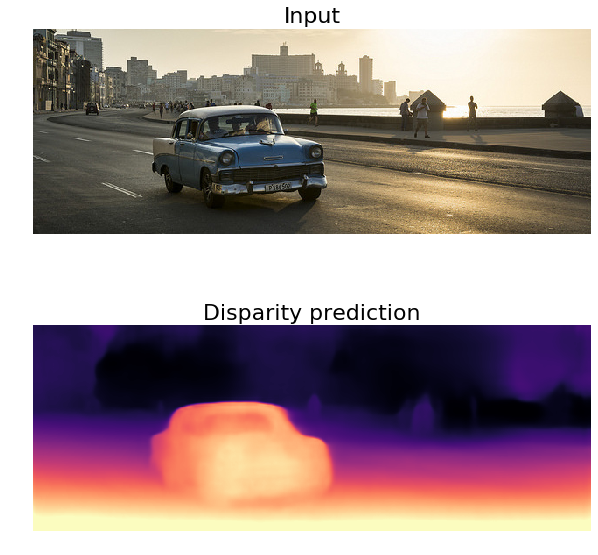

In [21]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=True)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

In [14]:
a = val_dataset[0][('color_aug', 's', 0)]
b = val_dataset[0][('color', 0, 0)]

In [15]:
class ss(nn.Module):
    """Layer to compute the SSIM loss between a pair of images
    """
    def __init__(self):
        super(ss, self).__init__()
        self.mu_x_pool   = nn.AvgPool2d(3, 1)
        self.mu_y_pool   = nn.AvgPool2d(3, 1)
        self.sig_x_pool  = nn.AvgPool2d(3, 1)
        self.sig_y_pool  = nn.AvgPool2d(3, 1)
        self.sig_xy_pool = nn.AvgPool2d(3, 1)

        self.refl = nn.ReflectionPad2d(1)

        self.C1 = 0.01 ** 2
        self.C2 = 0.03 ** 2

    def forward(self, x, y):
        x = self.refl(x)
        y = self.refl(y)

        mu_x = self.mu_x_pool(x)
        mu_y = self.mu_y_pool(y)

        sigma_x  = self.sig_x_pool(x ** 2) - mu_x ** 2
        sigma_y  = self.sig_y_pool(y ** 2) - mu_y ** 2
        sigma_xy = self.sig_xy_pool(x * y) - mu_x * mu_y

        SSIM_n = (2 * mu_x * mu_y + self.C1) * (2 * sigma_xy + self.C2)
        SSIM_d = (mu_x ** 2 + mu_y ** 2 + self.C1) * (sigma_x + sigma_y + self.C2)

        return torch.clamp((1 - SSIM_n / SSIM_d) / 2, 0, 1)


In [16]:
s = ss()

In [31]:
validation(encoder,decoder,val_loader)

KeyboardInterrupt: 

In [29]:
import os

test_path = "/home/ubuntu/monodepth2/kitti_data"

ftest = "/home/ubuntu/monodepth2/splits/eigen/test_files.txt"
test_filenames = open(ftest).readlines()


for f in test_filenames:
    path = f.split(" ")
    
    
    if path[2]=='l\n':
        image_path = os.path.join(test_path,path[0],"image_03/data",path[1])
    else:
        image_path = os.path.join(test_path,path[0],"image_04/data",path[1])
    print(image_path)
    input_image = pil.open(image_path+".jpg").convert('RGB')
    original_width, original_height = input_image.size
    input_image_resized = input_image.resize((width, height), pil.LANCZOS)
    input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)
    
    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        features = encoder(input_image_pytorch.to(device))
        outputs = decoder(features)

    disp = outputs[("disp", 0)]
    disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=True)

    # Saving colormapped depth image
    disp_resized_np = disp_resized.squeeze().cpu().numpy()
    vmax = np.percentile(disp_resized_np, 95)

    plt.figure(figsize=(10, 10))
    plt.subplot(211)
    plt.imshow(input_image)
    plt.title("Input", fontsize=22)
    plt.axis('off')

    plt.subplot(212)
    plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
    plt.title("Disparity prediction", fontsize=22)
    plt.axis('off');
    
    plt.savefig('output_imgs_10epochs/'+path[1]+'.png',dpi = 100)
    
    plt.close('all')
    del outputs,features



/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0002_sync/image_03/data/0000000069
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0002_sync/image_03/data/0000000054
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0002_sync/image_03/data/0000000042
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0002_sync/image_03/data/0000000057
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0002_sync/image_03/data/0000000030
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0002_sync/image_03/data/0000000027
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0002_sync/image_03/data/0000000012
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0002_sync/image_03/data/0000000075
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0002_sync/image_03/data/0000000036
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0002_sync/image_03/data/0000000033
/home/ubuntu/monodep

/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0020_sync/image_03/data/0000000015
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0020_sync/image_03/data/0000000066
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0020_sync/image_03/data/0000000006
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0020_sync/image_03/data/0000000048
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0020_sync/image_03/data/0000000060
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0020_sync/image_03/data/0000000009
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0020_sync/image_03/data/0000000033
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0020_sync/image_03/data/0000000021
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0020_sync/image_03/data/0000000075
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0020_sync/image_03/data/0000000027
/home/ubuntu/monodep

/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0029_sync/image_03/data/0000000070
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0029_sync/image_03/data/0000000310
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0029_sync/image_03/data/0000000154
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0029_sync/image_03/data/0000000098
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0029_sync/image_03/data/0000000408
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0029_sync/image_03/data/0000000042
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0029_sync/image_03/data/0000000338
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0036_sync/image_03/data/0000000000
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0036_sync/image_03/data/0000000128
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0036_sync/image_03/data/0000000192
/home/ubuntu/monodep

/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0052_sync/image_03/data/0000000050
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0052_sync/image_03/data/0000000040
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0052_sync/image_03/data/0000000008
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0052_sync/image_03/data/0000000016
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0052_sync/image_03/data/0000000044
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0052_sync/image_03/data/0000000018
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0052_sync/image_03/data/0000000032
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0052_sync/image_03/data/0000000042
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0052_sync/image_03/data/0000000010
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0052_sync/image_03/data/0000000020
/home/ubuntu/monodep

/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0064_sync/image_03/data/0000000396
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0064_sync/image_03/data/0000000154
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0064_sync/image_03/data/0000000374
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0064_sync/image_03/data/0000000088
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0064_sync/image_03/data/0000000286
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0064_sync/image_03/data/0000000550
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0064_sync/image_03/data/0000000264
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0064_sync/image_03/data/0000000220
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0064_sync/image_03/data/0000000330
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0064_sync/image_03/data/0000000484
/home/ubuntu/monodep

/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0093_sync/image_03/data/0000000401
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0093_sync/image_03/data/0000000417
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0096_sync/image_03/data/0000000000
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0096_sync/image_03/data/0000000019
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0096_sync/image_03/data/0000000038
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0096_sync/image_03/data/0000000057
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0096_sync/image_03/data/0000000076
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0096_sync/image_03/data/0000000095
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0096_sync/image_03/data/0000000114
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0096_sync/image_03/data/0000000133
/home/ubuntu/monodep

/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0117_sync/image_03/data/0000000416
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0117_sync/image_03/data/0000000364
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0117_sync/image_03/data/0000000026
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0117_sync/image_03/data/0000000078
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0117_sync/image_03/data/0000000572
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0117_sync/image_03/data/0000000468
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0117_sync/image_03/data/0000000260
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0117_sync/image_03/data/0000000624
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0117_sync/image_03/data/0000000234
/home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0117_sync/image_03/data/0000000442
/home/ubuntu/monodep

/home/ubuntu/monodepth2/kitti_data/2011_09_30/2011_09_30_drive_0016_sync/image_03/data/0000000044
/home/ubuntu/monodepth2/kitti_data/2011_09_30/2011_09_30_drive_0016_sync/image_03/data/0000000077
/home/ubuntu/monodepth2/kitti_data/2011_09_30/2011_09_30_drive_0016_sync/image_03/data/0000000066
/home/ubuntu/monodepth2/kitti_data/2011_09_30/2011_09_30_drive_0016_sync/image_03/data/0000000000
/home/ubuntu/monodepth2/kitti_data/2011_09_30/2011_09_30_drive_0016_sync/image_03/data/0000000165
/home/ubuntu/monodepth2/kitti_data/2011_09_30/2011_09_30_drive_0016_sync/image_03/data/0000000264
/home/ubuntu/monodepth2/kitti_data/2011_09_30/2011_09_30_drive_0016_sync/image_03/data/0000000253
/home/ubuntu/monodepth2/kitti_data/2011_09_30/2011_09_30_drive_0016_sync/image_03/data/0000000209
/home/ubuntu/monodepth2/kitti_data/2011_09_30/2011_09_30_drive_0016_sync/image_03/data/0000000121
/home/ubuntu/monodepth2/kitti_data/2011_09_30/2011_09_30_drive_0018_sync/image_03/data/0000000107
/home/ubuntu/monodep

/home/ubuntu/monodepth2/kitti_data/2011_10_03/2011_10_03_drive_0047_sync/image_03/data/0000000096
/home/ubuntu/monodepth2/kitti_data/2011_10_03/2011_10_03_drive_0047_sync/image_03/data/0000000800
/home/ubuntu/monodepth2/kitti_data/2011_10_03/2011_10_03_drive_0047_sync/image_03/data/0000000320
/home/ubuntu/monodepth2/kitti_data/2011_10_03/2011_10_03_drive_0047_sync/image_03/data/0000000576
/home/ubuntu/monodepth2/kitti_data/2011_10_03/2011_10_03_drive_0047_sync/image_03/data/0000000000
/home/ubuntu/monodepth2/kitti_data/2011_10_03/2011_10_03_drive_0047_sync/image_03/data/0000000480
/home/ubuntu/monodepth2/kitti_data/2011_10_03/2011_10_03_drive_0047_sync/image_03/data/0000000640
/home/ubuntu/monodepth2/kitti_data/2011_10_03/2011_10_03_drive_0047_sync/image_03/data/0000000032
/home/ubuntu/monodepth2/kitti_data/2011_10_03/2011_10_03_drive_0047_sync/image_03/data/0000000384
/home/ubuntu/monodepth2/kitti_data/2011_10_03/2011_10_03_drive_0047_sync/image_03/data/0000000160
/home/ubuntu/monodep

In [ ]:
image_path = "/home/ubuntu/monodepth2/assets/test_image.jpg"
input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size
input_image_resized = input_image.resize((width, height), pil.LANCZOS)
input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

In [30]:
torch.save(encoder,'encoder10e.pt')
torch.save(decoder,'decoder10e.pt')

In [30]:
encoder = torch.load('encoder10e.pt')
decoder = torch.load('decoder10e.pt')